## 針對貼圖進行影像前處理
1. 建立放置背景為黑的豬鼻子之空陣列
2. 將空陣列放入指定像素：
    * 將背景為白色之外的區域之像素存原來豬鼻子的像素
    * 將背景為白色的區域之像素存黑色

豬鼻子維度大小為： (225, 225, 3)


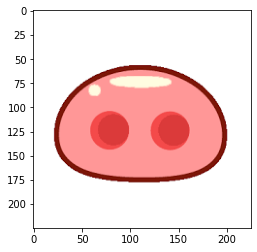

豬鼻子黑背景維度大小為： (225, 225, 3)


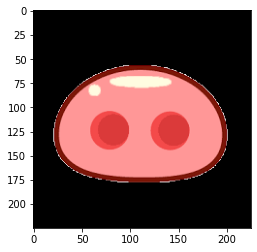

True

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 讀取豬鼻子影像，並轉為RGB
pig = cv2.imread('Image_posting/pig.png')
pig = cv2.cvtColor(pig, cv2.COLOR_BGR2RGB)

# 打印豬鼻子維度，分割RGB通道
print("豬鼻子維度大小為：", pig.shape)
r,g,b = cv2.split(pig)

# 顯示豬鼻子影像
plt.imshow(pig)
plt.show()

# 建立放置背景為黑的豬鼻子之空陣列，並指定此陣列只存放整數
black_pig = np.empty(pig.shape)
black_pig = black_pig.astype(int)

# 跑寬與高的多巢迴圈，設立條件式：將背景為白色之外的區域之像素存原來豬鼻子的像素;反之，背景為白色的區域之像素存黑色
for h in range(black_pig.shape[0]):
    for w in range(black_pig.shape[1]):
        if ((b[h][w]) == 255)&((g[h][w]) == 255)&((r[h][w]) == 255):
            black_pig[h][w][0]=0
            black_pig[h][w][1]=0
            black_pig[h][w][2]=0
        else:
            black_pig[h][w][0]=pig[h][w][0]
            black_pig[h][w][1]=pig[h][w][1]
            black_pig[h][w][2]=pig[h][w][2]

# 顯示背景為黑的豬鼻子影像
print("豬鼻子黑背景維度大小為：", black_pig.shape)
plt.imshow(black_pig)
plt.show()

# 儲存背景為黑的豬鼻子影像 #存為BGR的形式
cv2.imwrite("Image_posting/black_pig.jpg",black_pig)

## rotate
1. 輸入為影像、角度、中心點及放大尺度
2. 輸出為旋轉影像

In [2]:
def rotate(image, angle, center = None, scale = 1.0):
    
    # 取畫面寬高
    (h, w) = image.shape[:2]
    
    # 若中心點為無時，則中心點取影像的中心點
    if center is None:
        center = (w / 2, h / 2)
    
    # 產生旋轉矩陣Ｍ(第一個參數為旋轉中心，第二個參數旋轉角度，第三個參數：縮放比例)
    M = cv2.getRotationMatrix2D(center, angle, scale)
    
    # 透過旋轉矩陣進行影像旋轉
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

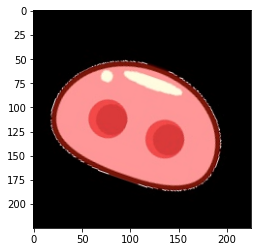

In [3]:
pig = cv2.imread('Image_posting/black_pig.jpg')

robpig = rotate(pig, -19.2545)
plt.imshow(robpig)
plt.show()

## 使用dlib偵測人臉特徵實現人臉貼圖
* 使用鼻子左右特徵來計算歐式距離，控制豬鼻子放置大小及位置
* 結合兩張影像區域，利用二值化方式

![](https://miro.medium.com/max/3840/1*stAhFcyYdNqGvV26xMdE7w.png)

人臉之位置 rectangles[[(683, 732) (1128, 1178)]]


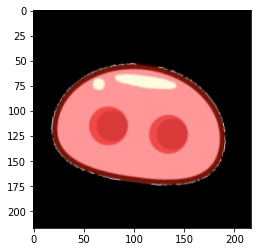

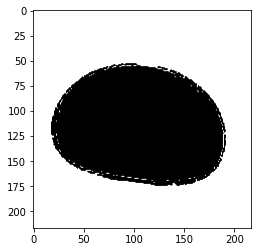

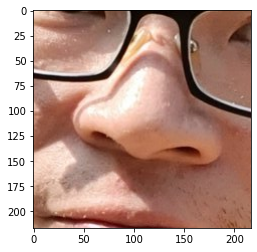

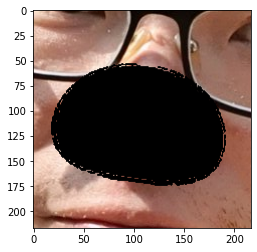

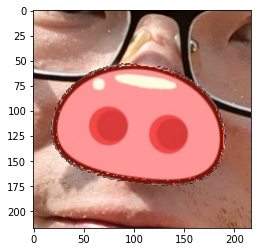

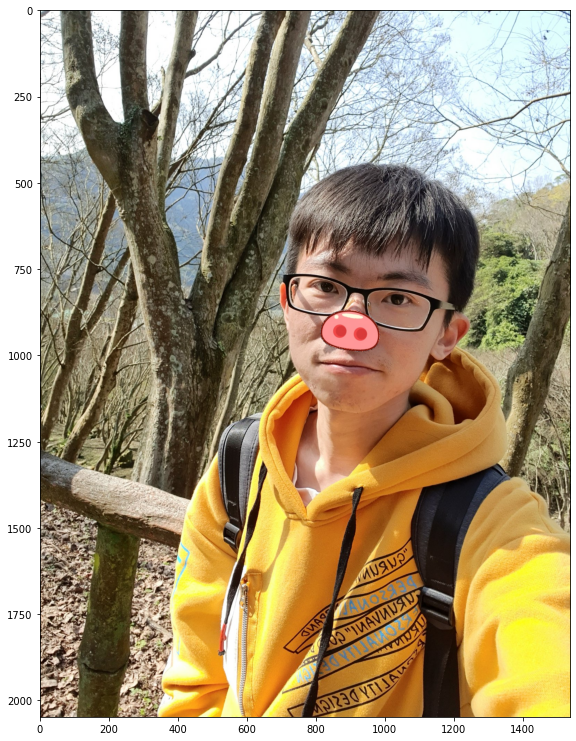

In [4]:
import dlib
from math import hypot
import math

# 讀取人臉辨識模型
detector = dlib.get_frontal_face_detector()

# 讀取人臉辨識之特徵模型
predictor = dlib.shape_predictor("Model/shape_predictor_68_face_landmarks.dat")

# 讀取影像（人臉與豬鼻子）
img = cv2.imread("Image_test/Face_test.jpeg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
black_pig = cv2.imread('Image_posting/black_pig.jpg')

# 影像維度
(h,w,c) = img.shape

# 影像代入人臉辨識模型，需帶入RGB影像
face = detector(img)
print("人臉之位置", face)

# 轉成灰階影像
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 將多個人臉帶入迴圈中
for face in face:
    
    # 使用灰階影像偵測臉特徵的詳細位置
    landmarks = predictor(img_gray, face)
    
    # 獲得鼻子上方、中間、左邊及右邊的座標位置
    top_nose = (landmarks.part(29).x, landmarks.part(29).y)
    center_nose = (landmarks.part(30).x, landmarks.part(30).y)
    left_nose = (landmarks.part(31).x, landmarks.part(31).y)
    right_nose = (landmarks.part(35).x, landmarks.part(35).y)
    
    # 計算角度
    nose_angle = float(-math.atan((right_nose[1]-left_nose[1])/(right_nose[0]-left_nose[0]))*180/3.14159)
    black_pig = rotate(black_pig, nose_angle)
    
    # 計算鼻子寬(鼻子左邊至右邊的歐式距離)，高度則是一樣（原因鼻子大小高寬相同），並定於2.2倍
    nose_width = int(hypot(left_nose[0]-right_nose[0],left_nose[1]-right_nose[1])*2.2)
    nose_height = int(nose_width)
    
    # 鼻子左上與右下的位置，即正方形
    top_left = (int(center_nose[0]-nose_width/2),int(center_nose[1]-nose_width/2))
    bottom_right = (int(center_nose[0]-nose_width/2),int(center_nose[1]-nose_width/2))
    
    # 改變豬鼻子大小，與我鼻子同寬高
    nose_pig = cv2.resize(black_pig, (nose_width, nose_height))
    plt.imshow(nose_pig)
    plt.show()
    
    # 豬鼻子變成灰階, 使用閥值變成二值化
    nose_pig_gray = cv2.cvtColor(nose_pig, cv2.COLOR_BGR2GRAY)
    _, nose_mask = cv2.threshold(nose_pig_gray, 25, 255, cv2.THRESH_BINARY_INV)
    plt.imshow(nose_mask, cmap ='gray')
    plt.show()
    
    # 條件式判斷貼圖是否會貼超出畫面
    if top_left[1]<0 or top_left[0]<0 or bottom_right[1]>h or bottom_right[0]>w:
        continue
    
    # 豬鼻子預放入的區域大小之鼻子部分
    nose_area = img[top_left[1]: top_left[1]+nose_height, top_left[0]: top_left[0]+nose_width]
    plt.imshow(nose_area)
    plt.show()
    
    # 每個畫素值進行二進位制“&”操作，1&1=1，1&0=0，0&1=0，0&0=0，
    nose_area_no_nose = cv2.bitwise_and(nose_area,nose_area,mask=nose_mask)
    plt.imshow(nose_area_no_nose)
    plt.show()
    
    # 將豬鼻子與真鼻子外影像結合的矩形
    final_nose = cv2.add(nose_area_no_nose, nose_pig)
    plt.imshow(final_nose)
    plt.show()
    
    # 將矩形放入原來影像之矩形
    img[top_left[1]: top_left[1]+nose_height, top_left[0]: top_left[0]+nose_width] = final_nose
    plt.figure(figsize=(15,13))
    plt.imshow(img)
    plt.show()

# 建立face_post_pig函數

In [6]:
#豬鼻子

import math

def face_post_pig(img, black_pig, detector, predictor, ):
    
    img = cv2.resize(img, None, fx=0.8, fy=0.8)
    (h,w,c) = img.shape
    face = detector(img)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    for face in face:
        
        landmarks = predictor(img_gray, face)
    
        top_nose = (landmarks.part(29).x, landmarks.part(29).y)
        center_nose = (landmarks.part(30).x, landmarks.part(30).y)
        left_nose = (landmarks.part(31).x, landmarks.part(31).y)
        right_nose = (landmarks.part(35).x, landmarks.part(35).y)
        
        nose_angle = float(-math.atan((right_nose[1]-left_nose[1])/(right_nose[0]-left_nose[0]))*180/3.14159)
        
        nose_width = int(hypot(left_nose[0]-right_nose[0],left_nose[1]-right_nose[1])*2)
        nose_height = int(nose_width)
    
        top_left = (int(center_nose[0]-nose_width/2),int(center_nose[1]-nose_width/2))
        bottom_right = (int(center_nose[0]-nose_width/2),int(center_nose[1]-nose_width/2))
        
        black_pig = rotate(black_pig, nose_angle)
        
        nose_pig = cv2.resize(black_pig, (nose_width, nose_height))
        nose_pig_gray = cv2.cvtColor(nose_pig, cv2.COLOR_BGR2GRAY)
        _, nose_mask = cv2.threshold(nose_pig_gray, 25, 255, cv2.THRESH_BINARY_INV)
        
        if top_left[1]<0 or top_left[0]<0 or bottom_right[1]>h or bottom_right[0]>w:
            continue
        
        nose_area = img[top_left[1]: top_left[1]+nose_height, top_left[0]: top_left[0]+nose_width]
        nose_area_no_nose = cv2.bitwise_and(nose_area,nose_area,mask=nose_mask)
        final_nose = cv2.add(nose_area_no_nose, nose_pig)
        img[top_left[1]: top_left[1]+nose_height, top_left[0]: top_left[0]+nose_width] = final_nose

    return img

In [7]:
import cv2
import dlib
from math import hypot

black_pig = cv2.imread('Image_posting/black_pig.jpg')
black_pig = cv2.cvtColor(black_pig, cv2.COLOR_BGR2RGB)

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("Model/shape_predictor_68_face_landmarks.dat")

VIDEO_IN = cv2.VideoCapture(0) 

while True:
    hasFrame, frame = VIDEO_IN.read()

    img = face_post_pig(frame, black_pig, detector, predictor)
    cv2.imshow("Frame", img)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
VIDEO_IN.release()
cv2.destroyAllWindows()